In [118]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../VT_SNN/")

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from snn_models.baseline_snn import SlayerMLP
from snn_models.multimodal_snn import SlayerMM
from dataset import ViTacDataset, ViTacMMDataset
from torch.utils.data import DataLoader
import slayerSNN as snn

import torch
import pandas as pd
from os import listdir
from os.path import isfile, join
import copy
import seaborn as sns

device = torch.device("cuda:0")

In [158]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # activation threshold
        "tauSr": 10.0, # time constant for srm kernel
        "tauRef": 1.0, # refractory kernel time constant
        "scaleRef": 2, # refractory kernel constant relative to theta
        "tauRho": 1, # pdf
        "scaleRho": 1, # membrane potential 
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
}

net_tact = SlayerMLP(params, 156, 32, 20).to(device)
net_vis = SlayerMLP(params, (50, 63, 2), 32, 20).to(device)
net_mm = SlayerMM(params,20).to(device)

In [159]:
tact_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/11fca6903e194c3d9608808b6439931f/tac_weights_500_03.pt'
vis_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/9261c0d745134135ba30adb922e320e7/vis_weights_500_03.pt'
mm_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/67fa81c8cf2d4c71b4f578a164d2e1be/mm_weights_500_03.pt'

data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN_new/'

In [160]:
net_vis = load_model(vis_run_dir, 'vis')
net_vis.eval()

net_mm = load_model(mm_run_dir, 'mm')
net_mm.eval()

net_tact = load_model(tact_run_dir, 'tac')
net_tact.eval()

SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(156, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(32, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [161]:
sample_file = 3
test_dataset = ViTacMMDataset(
    path=data_dir, sample_file=f"test_80_20_{sample_file}.txt", output_size=20
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=80, shuffle=False, num_workers=4
)

In [162]:
def plot_spikes(example, model_type):
    tact, vis, _, label = example
    input_index = 0
    tact = tact.unsqueeze(0).to(device="cuda")
    vis = vis.unsqueeze(0).to(device="cuda")
    if model_type == 'vis':
        out_spike = net_vis.forward(vis)
    elif model_type == 'tac':
        out_spike = net_tact.forward(tact)
    else:
        out_spike = net_mm.forward(tact, vis)
        
    ss = out_spike.squeeze().detach().cpu().numpy()
    lab = np.argmax(np.sum(ss, axis=1))
    return ss, lab

In [163]:
def load_model(path_to_model, model_type):
    if model_type == 'tac':
        net = copy.deepcopy(net_tact)
    elif model_type == 'vis':
        net = copy.deepcopy(net_vis)
    elif model_type == 'mm':
        net = copy.deepcopy(net_mm)
    
    net.load_state_dict(torch.load(path_to_model))
    return net

In [164]:
example = 2

In [165]:
output_spikes = {}
labels = {}
for mode_type in ['tac', 'vis', 'mm']:
    _, _, _,label = test_dataset[example]
    output_spikes[mode_type], labels[mode_type] = plot_spikes(test_dataset[example], mode_type)

In [166]:
import seaborn as sns
import matplotlib.pyplot as plot

In [169]:
labels['tac']

2

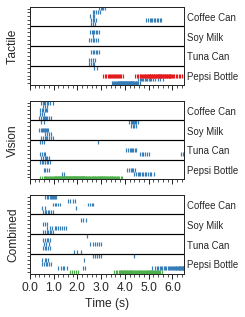

In [170]:
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True, 'font.sans-serif': 'Liberation Sans'},context='paper',
        style='white', palette='Set1')
fig, ax = plot.subplots(figsize=[3.5, 4.5], nrows=3, sharex=True)
cols = [sns.palettes.color_palette('Set1')[1], sns.palettes.color_palette('Set1')[0], sns.palettes.color_palette('Set1')[2]]
cols_tact = [cols[0]] * 20# + [cols[1]]* + [cols[0]] * 8
cols_tact[labels['tac']] = cols[1]
cols_corr = [cols[0]] * 20# + [cols[2]] + [cols[0]] * 17
cols_corr[labels['mm']] = cols[2]
ax[0].eventplot([np.argwhere(output_spikes['tac'][i] == 1).flatten() for i in range(20)], colors=cols_tact)
plot.xticks(np.arange(0, 325, 50), np.arange(0, 325, 50) * (6.5/325))
# ax[0].set_xticks(np.arange(0, 325, 10), minor=True)
# ax[0].tick_params(axis='x', which='minor')
ax[0].tick_params(labelsize=12)
ax[1].eventplot([np.argwhere(output_spikes['vis'][i] == 1).flatten() for i in range(20)], colors=cols_corr)
ax[2].eventplot([np.argwhere(output_spikes['mm'][i] == 1).flatten() for i in range(20)], colors=cols_corr)
plot.xticks(np.arange(0, 325, 50), np.arange(0, 325, 50) * (6.5/325))
ax[1].set_xticks(np.arange(0, 325, 10), minor=True)
ax[1].tick_params(axis='x', which='minor')
ax[0].set_ylim([-0.5, 19.5])
ax[1].set_ylim([-0.5, 19.5])
ax[2].set_ylim([-0.5, 19.5])
plot.xlim([0, 325])
ax[1].set_yticks([])
ax[0].set_yticks([])
ax[2].set_yticks([])
# plot.yticks(np.arange(0.4, 1.1, .1))
ax[1].tick_params(labelsize=12)
ax[0].set_ylabel('Tactile', fontsize=12)
ax[1].set_ylabel('Vision', fontsize=12)
ax[2].set_ylabel('Combined', fontsize=12)

ax[0].set_yticks(np.arange(0, 20, 1), minor=True)
ax[0].tick_params(axis='y', which='minor')
ax[1].set_yticks(np.arange(0, 20, 1), minor=True)
ax[1].tick_params(axis='y', which='minor')
ax[2].set_yticks(np.arange(0, 20, 1), minor=True)
ax[2].tick_params(axis='y', which='minor')

ax[0].plot(np.arange(325), np.ones(325) * 5.5 - 1, color='k')
ax[0].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 5, color='k')
ax[0].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 10, color='k')
ax[0].text(330, 1, 'Pepsi Bottle', rotation=0)
ax[0].text(330, 6, 'Tuna Can', rotation=0)
ax[0].text(330, 11, 'Soy Milk', rotation=0)
ax[0].text(330, 16, 'Coffee Can', rotation=0)

ax[1].plot(np.arange(325), np.ones(325) * 5.5 - 1, color='k')
ax[1].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 5, color='k')
ax[1].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 10, color='k')
ax[1].text(330, 1, 'Pepsi Bottle', rotation=0)
ax[1].text(330, 6, 'Tuna Can', rotation=0)
ax[1].text(330, 11, 'Soy Milk', rotation=0)
ax[1].text(330, 16, 'Coffee Can', rotation=0)

ax[2].plot(np.arange(325), np.ones(325) * 5.5 - 1, color='k')
ax[2].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 5, color='k')
ax[2].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 10, color='k')
ax[2].text(330, 1, 'Pepsi Bottle', rotation=0)
ax[2].text(330, 6, 'Tuna Can', rotation=0)
ax[2].text(330, 11, 'Soy Milk', rotation=0)
ax[2].text(330, 16, 'Coffee Can', rotation=0)

ax[2].tick_params(labelsize=12)
plot.xticks(fontsize=12)
# plot.yticks(fontsize=12)
plot.xlabel('Time (s)', fontsize=12)
# plot.ylabel('Tactile Spikes', fontsize=14)
plot.tight_layout()
plot.savefig('spike_class_output.pdf', dpi=300, bbox_inches='tight')
plot.show()

In [212]:
def ppp(output_spikes, labels):
    sns.set(rc={"xtick.bottom" : True, "ytick.left" : True, 'font.sans-serif': 'Liberation Sans'},context='paper',
        style='white', palette='Set1')
    fig, ax = plot.subplots(figsize=[3.5, 4.5], nrows=3, sharex=True)
    cols = [sns.palettes.color_palette('Set1')[1], sns.palettes.color_palette('Set1')[0], sns.palettes.color_palette('Set1')[2]]
    cols_tact = [cols[0]] * 20# + [cols[1]]* + [cols[0]] * 8
    cols_tact[labels['tac']] = cols[1]
    cols_corr = [cols[0]] * 20# + [cols[2]] + [cols[0]] * 17
    cols_corr[labels['mm']] = cols[2]
    ax[0].eventplot([np.argwhere(output_spikes['tac'][i] == 1).flatten() for i in range(20)], colors=cols_tact)
    plot.xticks(np.arange(0, 325, 50), np.arange(0, 325, 50) * (6.5/325))
    # ax[0].set_xticks(np.arange(0, 325, 10), minor=True)
    # ax[0].tick_params(axis='x', which='minor')
    ax[0].tick_params(labelsize=12)
    ax[1].eventplot([np.argwhere(output_spikes['vis'][i] == 1).flatten() for i in range(20)], colors=cols_corr)
    ax[2].eventplot([np.argwhere(output_spikes['mm'][i] == 1).flatten() for i in range(20)], colors=cols_corr)
    plot.xticks(np.arange(0, 325, 50), np.arange(0, 325, 50) * (6.5/325))
    ax[1].set_xticks(np.arange(0, 325, 10), minor=True)
    ax[1].tick_params(axis='x', which='minor')
    ax[0].set_ylim([-0.5, 19.5])
    ax[1].set_ylim([-0.5, 19.5])
    ax[2].set_ylim([-0.5, 19.5])
    plot.xlim([0, 325])
    ax[1].set_yticks([])
    ax[0].set_yticks([])
    ax[2].set_yticks([])
    # plot.yticks(np.arange(0.4, 1.1, .1))
    ax[1].tick_params(labelsize=12)
    ax[0].set_ylabel('Tactile', fontsize=12)
    ax[1].set_ylabel('Vision', fontsize=12)
    ax[2].set_ylabel('Combined', fontsize=12)

    ax[0].set_yticks(np.arange(0, 20, 1), minor=True)
    ax[0].tick_params(axis='y', which='minor')
    ax[1].set_yticks(np.arange(0, 20, 1), minor=True)
    ax[1].tick_params(axis='y', which='minor')
    ax[2].set_yticks(np.arange(0, 20, 1), minor=True)
    ax[2].tick_params(axis='y', which='minor')

    ax[0].plot(np.arange(325), np.ones(325) * 5.5 - 1, color='k')
    ax[0].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 5, color='k')
    ax[0].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 10, color='k')
    ax[0].text(330, 1, 'Pepsi Bottle', rotation=0)
    ax[0].text(330, 6, 'Tuna Can', rotation=0)
    ax[0].text(330, 11, 'Soy Milk', rotation=0)
    ax[0].text(330, 16, 'Coffee Can', rotation=0)

    ax[1].plot(np.arange(325), np.ones(325) * 5.5 - 1, color='k')
    ax[1].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 5, color='k')
    ax[1].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 10, color='k')
    ax[1].text(330, 1, 'Pepsi Bottle', rotation=0)
    ax[1].text(330, 6, 'Tuna Can', rotation=0)
    ax[1].text(330, 11, 'Soy Milk', rotation=0)
    ax[1].text(330, 16, 'Coffee Can', rotation=0)

    ax[2].plot(np.arange(325), np.ones(325) * 5.5 - 1, color='k')
    ax[2].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 5, color='k')
    ax[2].plot(np.arange(325), np.ones(325) * 5.5 - 1 + 10, color='k')
    ax[2].text(330, 1, 'Pepsi Bottle', rotation=0)
    ax[2].text(330, 6, 'Tuna Can', rotation=0)
    ax[2].text(330, 11, 'Soy Milk', rotation=0)
    ax[2].text(330, 16, 'Coffee Can', rotation=0)

    ax[2].tick_params(labelsize=12)
    plot.xticks(fontsize=12)
    # plot.yticks(fontsize=12)
    plot.xlabel('Time (s)', fontsize=12)
    # plot.ylabel('Tactile Spikes', fontsize=14)
    plot.tight_layout()
    plot.savefig('spike_class_output_new.pdf', dpi=300, bbox_inches='tight')
    plot.show()

Example i 2
0 {'tac': 2, 'vis': 0, 'mm': 0}


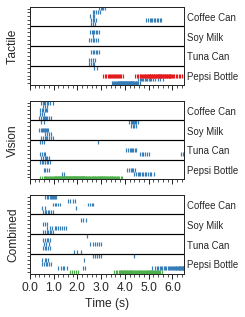

Example i 3
1 {'tac': 2, 'vis': 1, 'mm': 1}


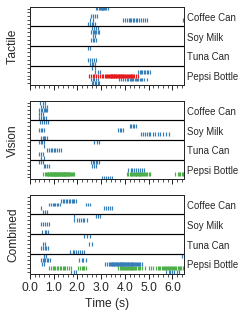

Example i 4
1 {'tac': 2, 'vis': 1, 'mm': 1}


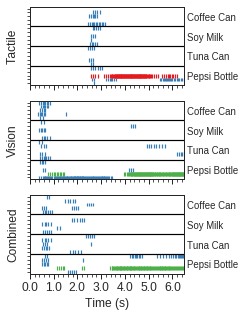

Example i 5
1 {'tac': 2, 'vis': 1, 'mm': 0}


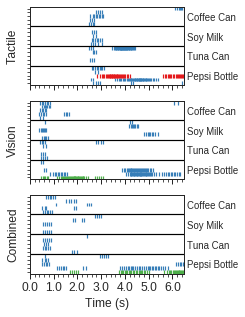

Example i 6
2 {'tac': 1, 'vis': 2, 'mm': 2}


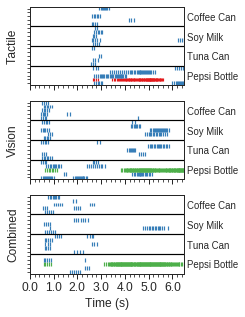

Example i 7
2 {'tac': 0, 'vis': 2, 'mm': 2}


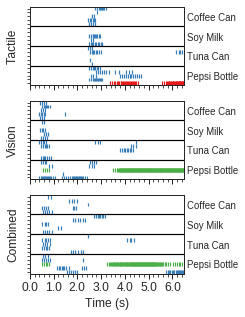

Example i 10
3 {'tac': 2, 'vis': 3, 'mm': 3}


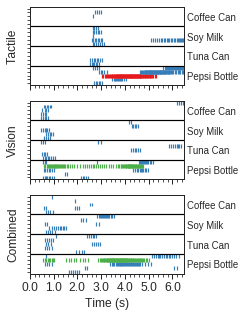

Example i 21
7 {'tac': 8, 'vis': 7, 'mm': 7}


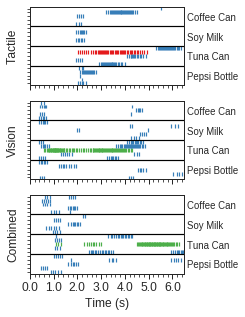

Example i 22
7 {'tac': 8, 'vis': 7, 'mm': 5}


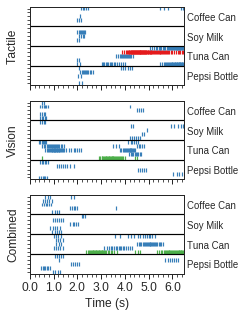

Example i 26
8 {'tac': 8, 'vis': 8, 'mm': 7}


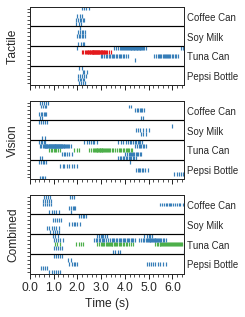

Example i 30
10 {'tac': 16, 'vis': 10, 'mm': 11}


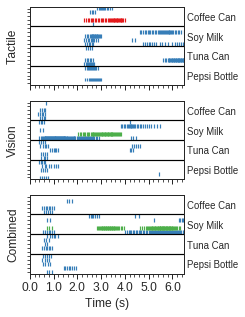

Example i 32
10 {'tac': 14, 'vis': 10, 'mm': 14}


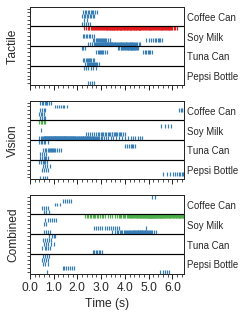

Example i 34
11 {'tac': 12, 'vis': 12, 'mm': 12}


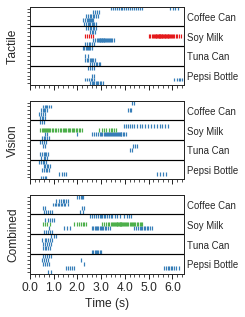

Example i 35
11 {'tac': 11, 'vis': 12, 'mm': 11}


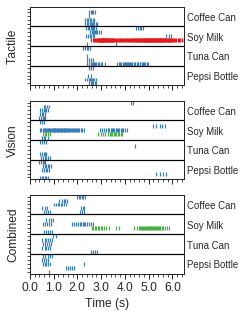

Example i 37
12 {'tac': 11, 'vis': 12, 'mm': 12}


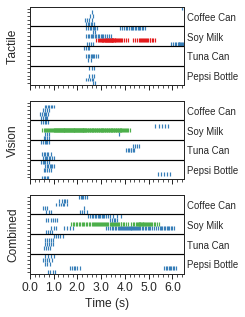

Example i 38
12 {'tac': 12, 'vis': 13, 'mm': 12}


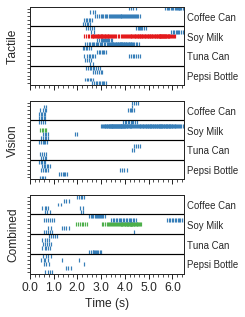

Example i 40
13 {'tac': 16, 'vis': 13, 'mm': 13}


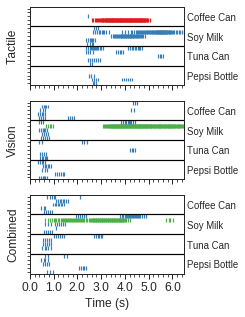

Example i 42
14 {'tac': 14, 'vis': 12, 'mm': 14}


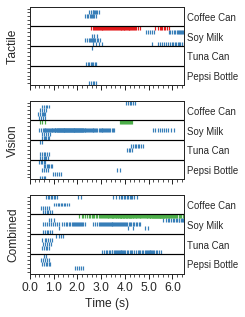

Example i 43
14 {'tac': 12, 'vis': 14, 'mm': 14}


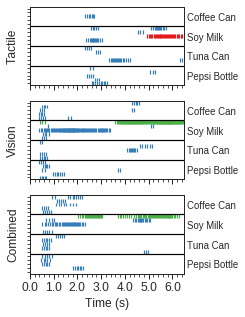

Example i 44
14 {'tac': 13, 'vis': 14, 'mm': 14}


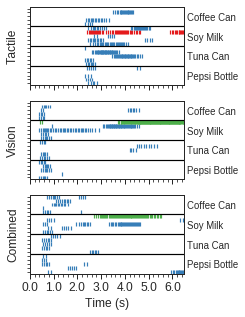

Example i 45
15 {'tac': 15, 'vis': 16, 'mm': 15}


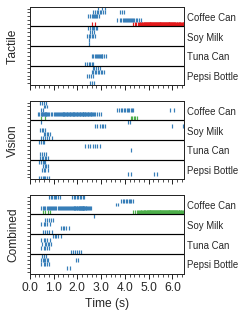

Example i 46
15 {'tac': 15, 'vis': 15, 'mm': 19}


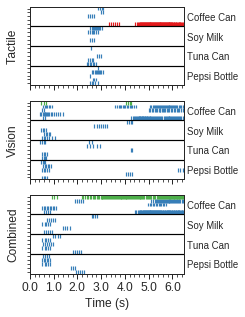

Example i 50
16 {'tac': 18, 'vis': 16, 'mm': 16}


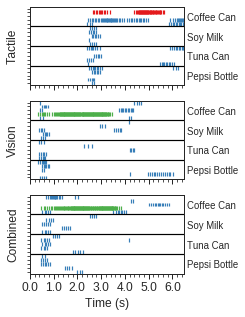

Example i 51
17 {'tac': 16, 'vis': 17, 'mm': 18}


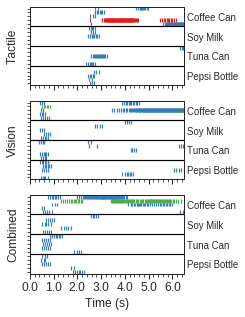

Example i 52
17 {'tac': 17, 'vis': 17, 'mm': 19}


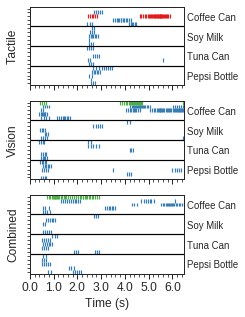

Example i 53
17 {'tac': 17, 'vis': 17, 'mm': 19}


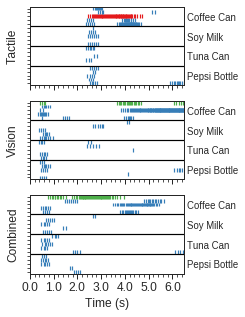

Example i 54
18 {'tac': 18, 'vis': 17, 'mm': 17}


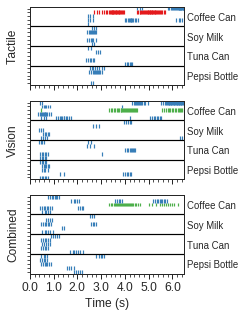

Example i 55
18 {'tac': 18, 'vis': 19, 'mm': 18}


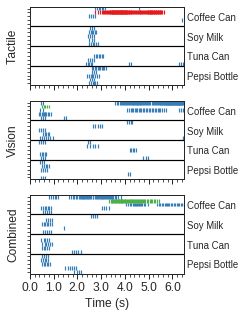

Example i 56
18 {'tac': 18, 'vis': 17, 'mm': 19}


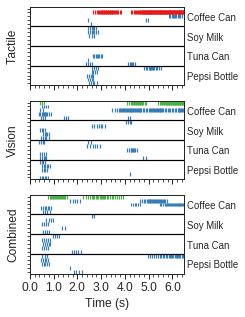

Example i 57
19 {'tac': 19, 'vis': 18, 'mm': 18}


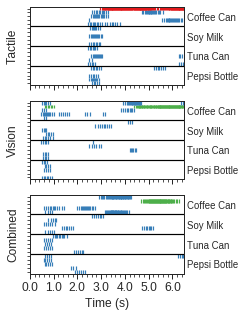

Example i 59
19 {'tac': 19, 'vis': 19, 'mm': 15}


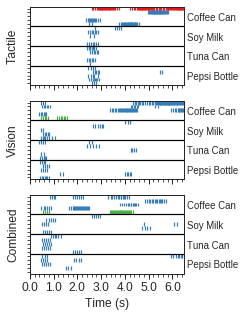

In [176]:
for i in range(len(test_dataset)):
    
    output_spikes = {}
    labels = {}
    for mode_type in ['tac', 'vis', 'mm']:
        _, _, _,label = test_dataset[i]
        output_spikes[mode_type], labels[mode_type] = plot_spikes(test_dataset[i], mode_type)
        
    show = False
    for mode_type in ['tac', 'vis', 'mm']:
        if labels[mode_type] != label:
            show=True
        
    if show:
        print('Example i', i)
        print(label, labels)
        ppp( output_spikes , labels)

In [183]:
output_spikes = {}
labels = {}
for mode_type in ['tac', 'vis', 'mm']:
    _, _, _,label = test_dataset[example]
    output_spikes[mode_type], labels[mode_type] = plot_spikes(test_dataset[44], mode_type)

In [195]:
labels['tac'] = 18

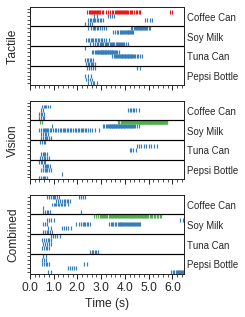

In [213]:
ppp( output_spikes , labels)